In [1]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
import cv2
from glob import glob
import seaborn as sns
from PIL import Image
import pickle as pkl

In [2]:
lesion_type_dict = {'akiec': 'Actinic keratoses',
                    'bcc': 'Basal cell carcinoma',
                    'bkl': 'Benign keratosis-like lesions ',
                    'df': 'Dermatofibroma',
                    'nv': 'Melanocytic nevi',
                    'mel': 'Melanoma',
                    'vasc': 'Vascular lesions'}

base_skin_dir = os.path.join('..','input')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x for x in glob(os.path.join(base_skin_dir,'*','*','*.jpg'))}
skin_df = pd.read_csv('../input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')
skin_df.head(5)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [3]:
skin_df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [4]:
skin_df.fillna((skin_df['age'].mean()),inplace=True)
skin_df.isnull().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

<AxesSubplot:>

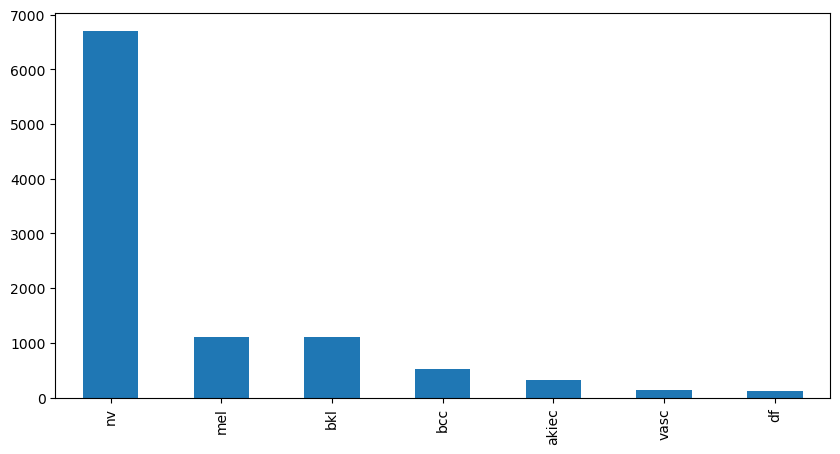

In [5]:
fig, ax1 = plt.subplots(1,1,figsize=(10, 5))
skin_df['dx'].value_counts().plot(kind='bar',ax=ax1)

<AxesSubplot:>

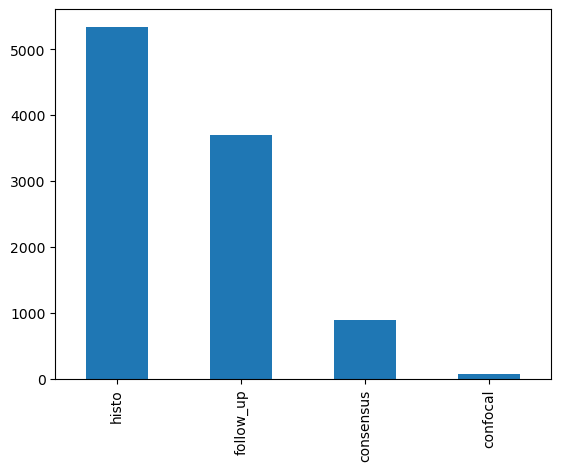

In [6]:
skin_df['dx_type'].value_counts().plot(kind='bar')

<AxesSubplot:>

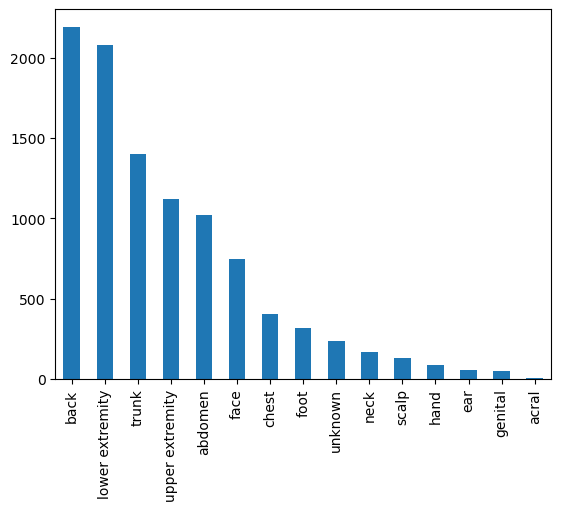

In [7]:
skin_df['localization'].value_counts().plot(kind='bar')

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

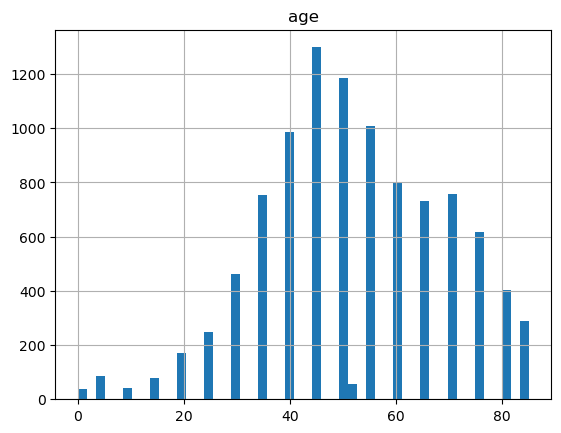

In [8]:
skin_df.hist(bins=50)

<AxesSubplot:>

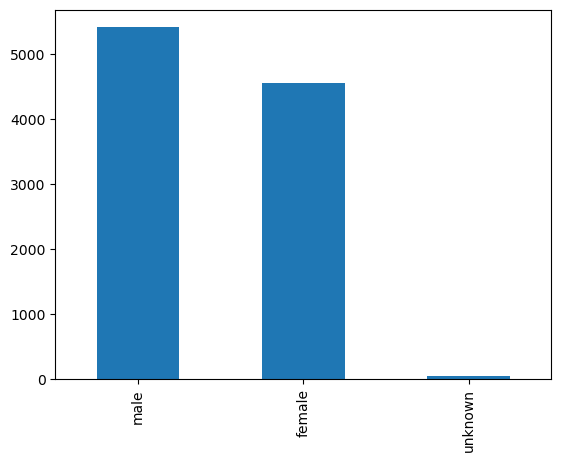

In [9]:
skin_df['sex'].value_counts().plot(kind='bar')

In [10]:
skin1=[]
skin2=[]
for x in skin_df['image_id']:
    if x in imageid_path_dict:
        skin1.append(imageid_path_dict.get(x))
skin_1 = pd.DataFrame(skin1)
skin_df['path']=skin_1

for x in skin_df['dx']:
    if x in lesion_type_dict:
        skin2.append(lesion_type_dict.get(x))

skin_2 = pd.DataFrame(skin2)
skin_df['cell_type']=skin_2

skin_df['cell_type_idx'] = pd.Categorical(skin_df['cell_type']).codes
skin_df.groupby(['dx']).count()

print(skin_df)

         lesion_id      image_id     dx dx_type   age     sex localization  \
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp   
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp   
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp   
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp   
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear   
...            ...           ...    ...     ...   ...     ...          ...   
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen   
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen   
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen   
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face   
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back   

                                                    path  \
0  

In [11]:
def features_data():
    skin_df['image'] = skin_df['path'].map(lambda x:
                                           np.asarray(Image.open(x).resize((120,120))))
    return skin_df['image']

In [12]:
images=[]
for x in skin_df['image_id']:
    images.append(x)
#print(images)        
hair_images =images

def hair_remove(image):
    # converts image to grayScale
    grayScale = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    # kernel for morphologyEx
    kernel = cv2.getStructuringElement(1,(10,10))
    # apply MORPH_BLACKHAT to grayScale image
    blackhat = cv2.morphologyEx(grayScale, cv2.MORPH_BLACKHAT, kernel)
    # apply thresholding to blackhat
    _,threshold = cv2.threshold(blackhat,10,255,cv2.THRESH_BINARY)
    # inpaint with original image and threshold image
    final_image = cv2.inpaint(image,threshold,5,cv2.INPAINT_TELEA)
    
    return final_image

features_list=[]
for i,image_name in enumerate(hair_images[0:10015]):
    image = cv2.imread(imageid_path_dict.get(image_name))
    image_resize = cv2.resize(image,(120,120))
    final_image = hair_remove(image_resize)
    final_image=cv2.cvtColor(final_image, cv2.COLOR_BGR2RGB)
    features_list.append(final_image)
    
skin_df['image_pp']=features_list    
#print(skin_df['image_pp'])

pkl.dump(skin_df['image_pp'],open('image_pp','wb'))

In [13]:
skin_df['image_pp']=pkl.load(open('/kaggle/working/image_pp','rb'))

import scipy.ndimage as ndimage
skin_df['image_pp'] = ndimage.gaussian_laplace(skin_df['image_pp'], sigma = 0)

In [14]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

features=skin_df.drop(columns=['cell_type_idx'],axis=1)
target=skin_df['cell_type_idx']

x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.2,random_state=666)
y_test = to_categorical(y_test_o, num_classes = 7)
x_test = np.asarray(x_test_o['image_pp'].tolist())
x_train, x_validate, y_train, y_validate = train_test_split(x_train_o, y_train_o, test_size = 0.2, random_state = 999)
x_validate=np.asarray(x_validate['image_pp'].tolist())
y_validate = to_categorical(y_validate, num_classes = 7)
X = pd.concat([x_train, y_train], axis=1)

cls_0=X[X.cell_type_idx==0]
cls_1=X[X.cell_type_idx==1]
cls_2=X[X.cell_type_idx==2]
cls_3=X[X.cell_type_idx==3]
cls_4=X[X.cell_type_idx==4]
cls_5=X[X.cell_type_idx==5]
cls_6=X[X.cell_type_idx==6]

from sklearn.utils import resample

cls_0_upsampled = resample(cls_0,replace=True,n_samples=1000, random_state=9)
cls_1_upsampled = resample(cls_1,replace=True,n_samples=1000, random_state=9)
cls_3_upsampled = resample(cls_3,replace=True,n_samples=2000, random_state=9) 
cls_6_upsampled = resample(cls_6,replace=True,n_samples=1000, random_state=9)
                           

print('Random under-sampling:')
sampled = pd.concat([cls_0_upsampled,cls_1_upsampled,cls_2,cls_3_upsampled,cls_4,cls_5,cls_6_upsampled])

print(sampled.cell_type_idx.value_counts())

x_train=np.asarray(sampled['image_pp'].tolist())
y_train = to_categorical(sampled['cell_type_idx'], num_classes = 7)

Random under-sampling:
4    4290
3    2000
0    1000
1    1000
6    1000
5     707
2     703
Name: cell_type_idx, dtype: int64


In [15]:
print(x_train.shape)
print(x_test.shape)
print(x_validate.shape)
print(y_train.shape)
print(y_test.shape)
print(y_validate.shape)

(10700, 120, 120, 3)
(2003, 120, 120, 3)
(1603, 120, 120, 3)
(10700, 7)
(2003, 7)
(1603, 7)


In [16]:
x_train = x_train.reshape(x_train.shape[0], *(120, 120, 3))
x_test = x_test.reshape(x_test.shape[0], *(120, 120, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(120,120, 3))
input_shape = (120,120,3)
num_classes = 7

In [17]:
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Nadam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
import scikitplot.plotters as skplt
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import random

In [18]:
def select_optimizer(choice):
    if(choice==0):
        optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
        return optimizer
    elif (choice==1):
        optimizer = tf.keras.optimizers.SGD()
        return optimizer
    elif (choice==2):
        optimizer = tf.keras.optimizers.SGD(momentum=0.9,nesterov=True)
        return optimizer
    elif (choice==3):
        optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001)
        return optimizer
    elif (choice==4):
        optimizer = Nadam()
        return optimizer

In [19]:
def network_evaluation(model):
    print("[INFO] evaluating network...")
    predIdxs = model.predict(x_test, batch_size=100)
    skplt.plot_roc_curve(y_test.argmax(axis=1),predIdxs)
    plt.show()

In [20]:
def plot_loss_accuracy(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epochs')
    plt.legend(['accuracy', 'val_accuracy'])
    plt.show()

    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('loss')
    plt.ylabel('loss')
    plt.xlabel('Epochs')
    plt.legend(['loss','val_loss'])
    plt.show()

In [21]:
class History_trained_model(object):
    def __init__(self, history, epoch, params):
        self.history = history
        self.epoch = epoch
        self.params = params

In [22]:
categories = ['Actinic keratoses',
              'Basal cell carcinoma',
              'Benign keratosis-like lesions ', 
              'Dermatofibroma', 
              'Melanocytic nevi', 
              'Melanoma',
              'Vascular lesions']
class_ids = {0:'Actinic keratoses',
              1:'Basal cell carcinoma',
              2:'Benign keratosis-like lesions ', 
              3:'Dermatofibroma', 
              4:'Melanocytic nevi', 
              5:'Melanoma',
              6:'Vascular lesions'}

In [23]:
def cm_pred(y_test_o,predictions):
    y_test_o=y_test_o
    predictions = np.array(list(map(lambda x: np.argmax(x), predictions)))
    #print(predictions)
    print(classification_report(y_test_o, predictions, target_names=categories))
    CMatrix = pd.DataFrame(confusion_matrix(y_test_o, predictions), columns=categories, index =categories)
    plt.figure(figsize=(12, 6)) 
    ax = sns.heatmap(CMatrix, annot = True, fmt = 'g' ,vmin = 0, vmax = 10,cmap = 'YlGnBu') 
    ax.set_xlabel('Predicted',fontsize = 14,weight = 'bold') 
    ax.set_xticklabels(ax.get_xticklabels(),rotation =90); 
    ax.set_ylabel('Actual',fontsize = 14,weight = 'bold')
    ax.set_title('Confusion Matrix - Test Set',fontsize = 16,weight = 'bold',pad=20);
    plt.show()
    y_test_o = pd.DataFrame(y_test_o)
    y_test_o['predictions']=predictions
    

    fig=plt.figure(figsize=(20,20))
    for i in range (1,26):
        x=random.choice(list(x_test_o.index.values))
        fig.add_subplot(5,5,i)
        plt.imshow(x_test_o['image_pp'][x],cmap="gray")
        if y_test_o['predictions'][x] == skin_df['cell_type_idx'][x]:
            title_color = "green"
        else :
            title_color="red"
        plt.title(class_ids[y_test_o['predictions'][x]],fontdict={'fontsize':18},color=title_color)
        plt.axis('off')
    plt.suptitle("Model Predictions")  
    plt.show()

In [24]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=6, verbose=1, factor=0.05, min_learning_rate=0.00001)
es = EarlyStopping(monitor='val_accuracy',verbose=1, patience=40,mode='max')

In [25]:
from tensorflow.keras.applications.mobilenet import preprocess_input

datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
        rotation_range=40,
        vertical_flip=True) 
datagen.fit(x_train)

In [26]:
lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

skin_df['lesion_ID'] = skin_df['dx'].map(lesion_ID_dict)

from sklearn.utils.class_weight import compute_class_weight
y_id = np.array(skin_df['lesion_ID'])

# compute weights for the loss function, because the problem is unbalanced
class_weights = np.around(compute_class_weight(class_weight='balanced',classes=np.unique(y_id),y=sampled['cell_type_idx']),2)
class_weights = dict(zip(np.unique(y_id),class_weights))

print('The problem is unbalanced. We need to provide class_weights ')
print(class_weights)

The problem is unbalanced. We need to provide class_weights 
{0: 1.53, 1: 1.53, 2: 2.17, 3: 0.76, 4: 0.36, 5: 2.16, 6: 1.53}


In [27]:
from tensorflow.keras.applications import ResNet152, Xception
from tensorflow.keras.models import Sequential, Model,load_model
from tensorflow.keras.layers import Activation,Dense,AveragePooling2D,SpatialDropout2D, Dropout, Flatten, Conv2D, MaxPooling2D,GlobalAveragePooling2D,GlobalMaxPooling2D,BatchNormalization,MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint

In [28]:
ResNet152_base = ResNet152(include_top=False, weights='imagenet',
                           input_tensor=None, input_shape=(120,120,3))


print('Adding new layers...')
output = ResNet152_base.get_layer(index = -1).output
output = GlobalAveragePooling2D()(output)
output = BatchNormalization()(output)
output = Dense(120, activation="relu",kernel_regularizer='l2')(output)
output = Dropout(0.5)(output)
output = BatchNormalization()(output)
output = Dense(7, activation="softmax")(output)
print('New layers added!')
ResNet152_model = Model(ResNet152_base.input, output)

from tensorflow.keras import layers
for layer in ResNet152_model.layers[:-6]:
    layer.trainable = False
    
mcp = ModelCheckpoint(monitor='val_accuracy', patience=6, verbose=1,filepath='./ResNet152_model.h5',save_best_only=True,mode='max')
ResNet152_model.compile(optimizer = select_optimizer(0) , loss = "categorical_crossentropy", metrics=["accuracy"])
history_resnet152 = ResNet152_model.fit(x_train,y_train, batch_size=100,
                              epochs = 100, validation_data =(x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // 100
                              ,callbacks=[learning_rate_reduction,es,mcp])

234698864/234698864 [==============================] - 1s 0us/step
Adding new layers...
New layers added!
Epoch 1/100
107/107 [==============================] - ETA: 0s - loss: 2.7418 - accuracy: 0.6316
Epoch 1: val_accuracy improved from -inf to 0.70930, saving model to ./ResNet152_model.h5
107/107 [==============================] - 46s 282ms/step - loss: 2.7418 - accuracy: 0.6316 - val_loss: 1.8797 - val_accuracy: 0.7093 - lr: 0.0010
Epoch 2/100
107/107 [==============================] - ETA: 0s - loss: 1.4475 - accuracy: 0.7733
Epoch 2: val_accuracy did not improve from 0.70930
107/107 [==============================] - 28s 260ms/step - loss: 1.4475 - accuracy: 0.7733 - val_loss: 1.3669 - val_accuracy: 0.6937 - lr: 0.0010
Epoch 3/100
107/107 [==============================] - ETA: 0s - loss: 1.0499 - accuracy: 0.8016
Epoch 3: val_accuracy improved from 0.70930 to 0.72240, saving model to ./ResNet152_model.h5
107/107 [==============================] - 29s 272ms/step - loss: 1.0499 - 

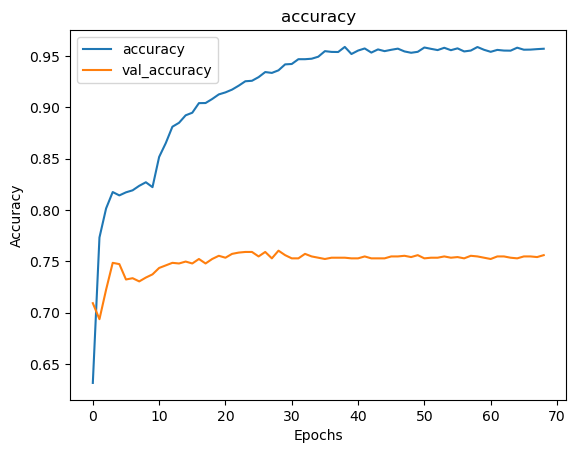

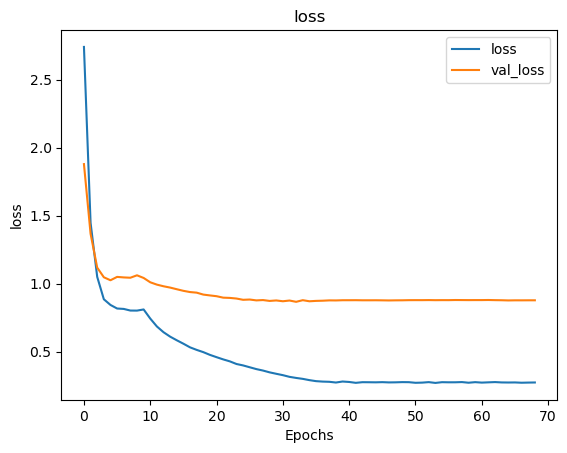

loaded model.....
[INFO] evaluating network...
21/21 [==============================] - 7s 226ms/step


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; This will be removed in v0.4.0. Please use scikitplot.metrics.plot_roc_curve instead.
  warnings.warn(msg, category=FutureWarning)


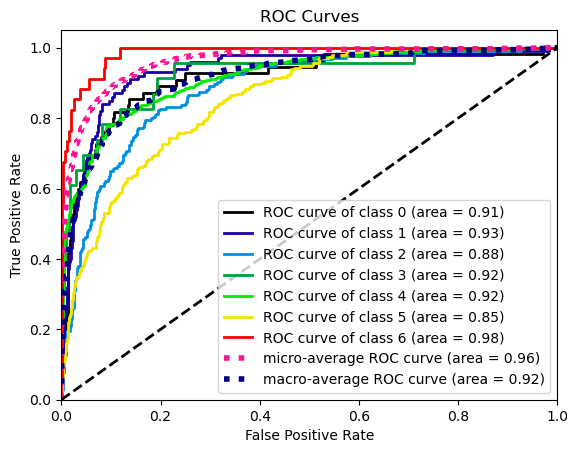

In [29]:
plot_loss_accuracy(history_resnet152)
with open('history_resnet101', 'wb') as file:
    model_history= History_trained_model(history_resnet152.history, history_resnet152.epoch, history_resnet152.params)
    pkl.dump(model_history, file)
ResNet152_model.save("ResNet152_model.h5")
ResNet152_model.save_weights("ResNet152_model_weights.h5")
from keras.models import load_model
ResNet152_model=load_model('ResNet152_model.h5')
print('loaded model.....')
ResNet152_model.load_weights('ResNet152_model_weights.h5')

network_evaluation(ResNet152_model)

63/63 [==============================] - 6s 91ms/step
Training: accuracy = 0.977944
Validation: accuracy = 0.756082
Test: accuracy = 0.763355
                                precision    recall  f1-score   support

             Actinic keratoses       0.39      0.44      0.41        55
          Basal cell carcinoma       0.50      0.45      0.47       100
Benign keratosis-like lesions        0.54      0.44      0.48       214
                Dermatofibroma       0.50      0.30      0.38        23
              Melanocytic nevi       0.84      0.93      0.89      1347
                      Melanoma       0.56      0.37      0.44       230
              Vascular lesions       0.81      0.50      0.62        34

                      accuracy                           0.76      2003
                     macro avg       0.59      0.49      0.53      2003
                  weighted avg       0.74      0.76      0.75      2003



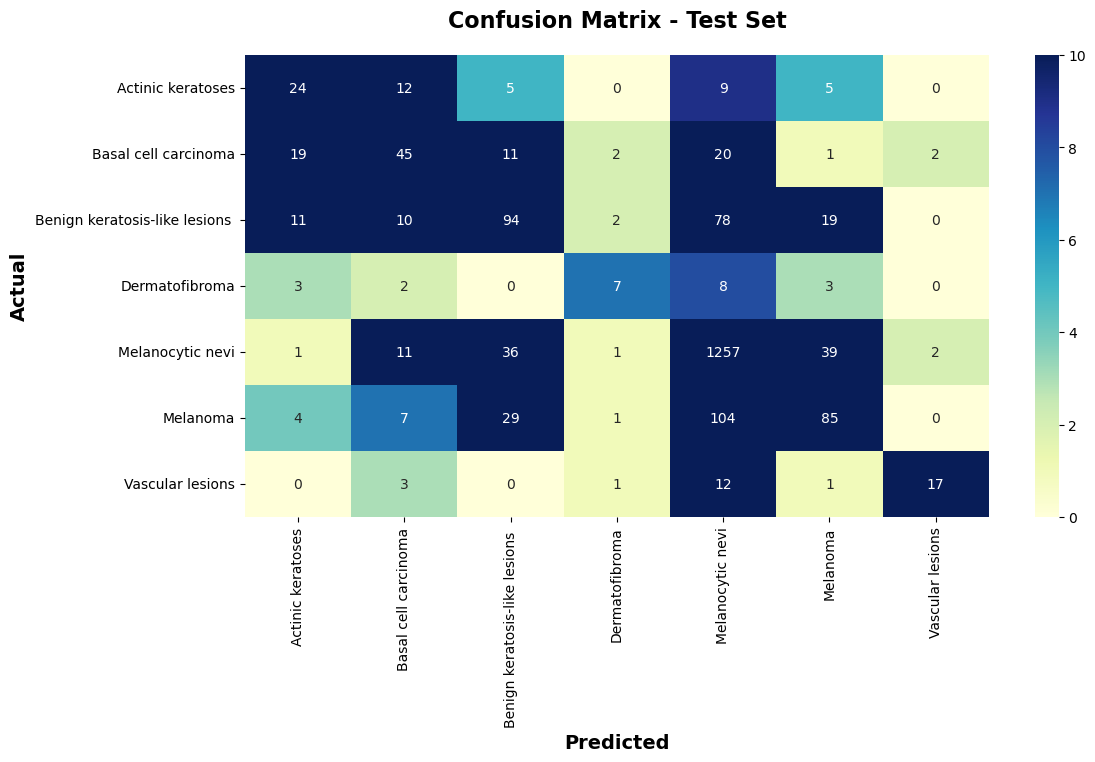

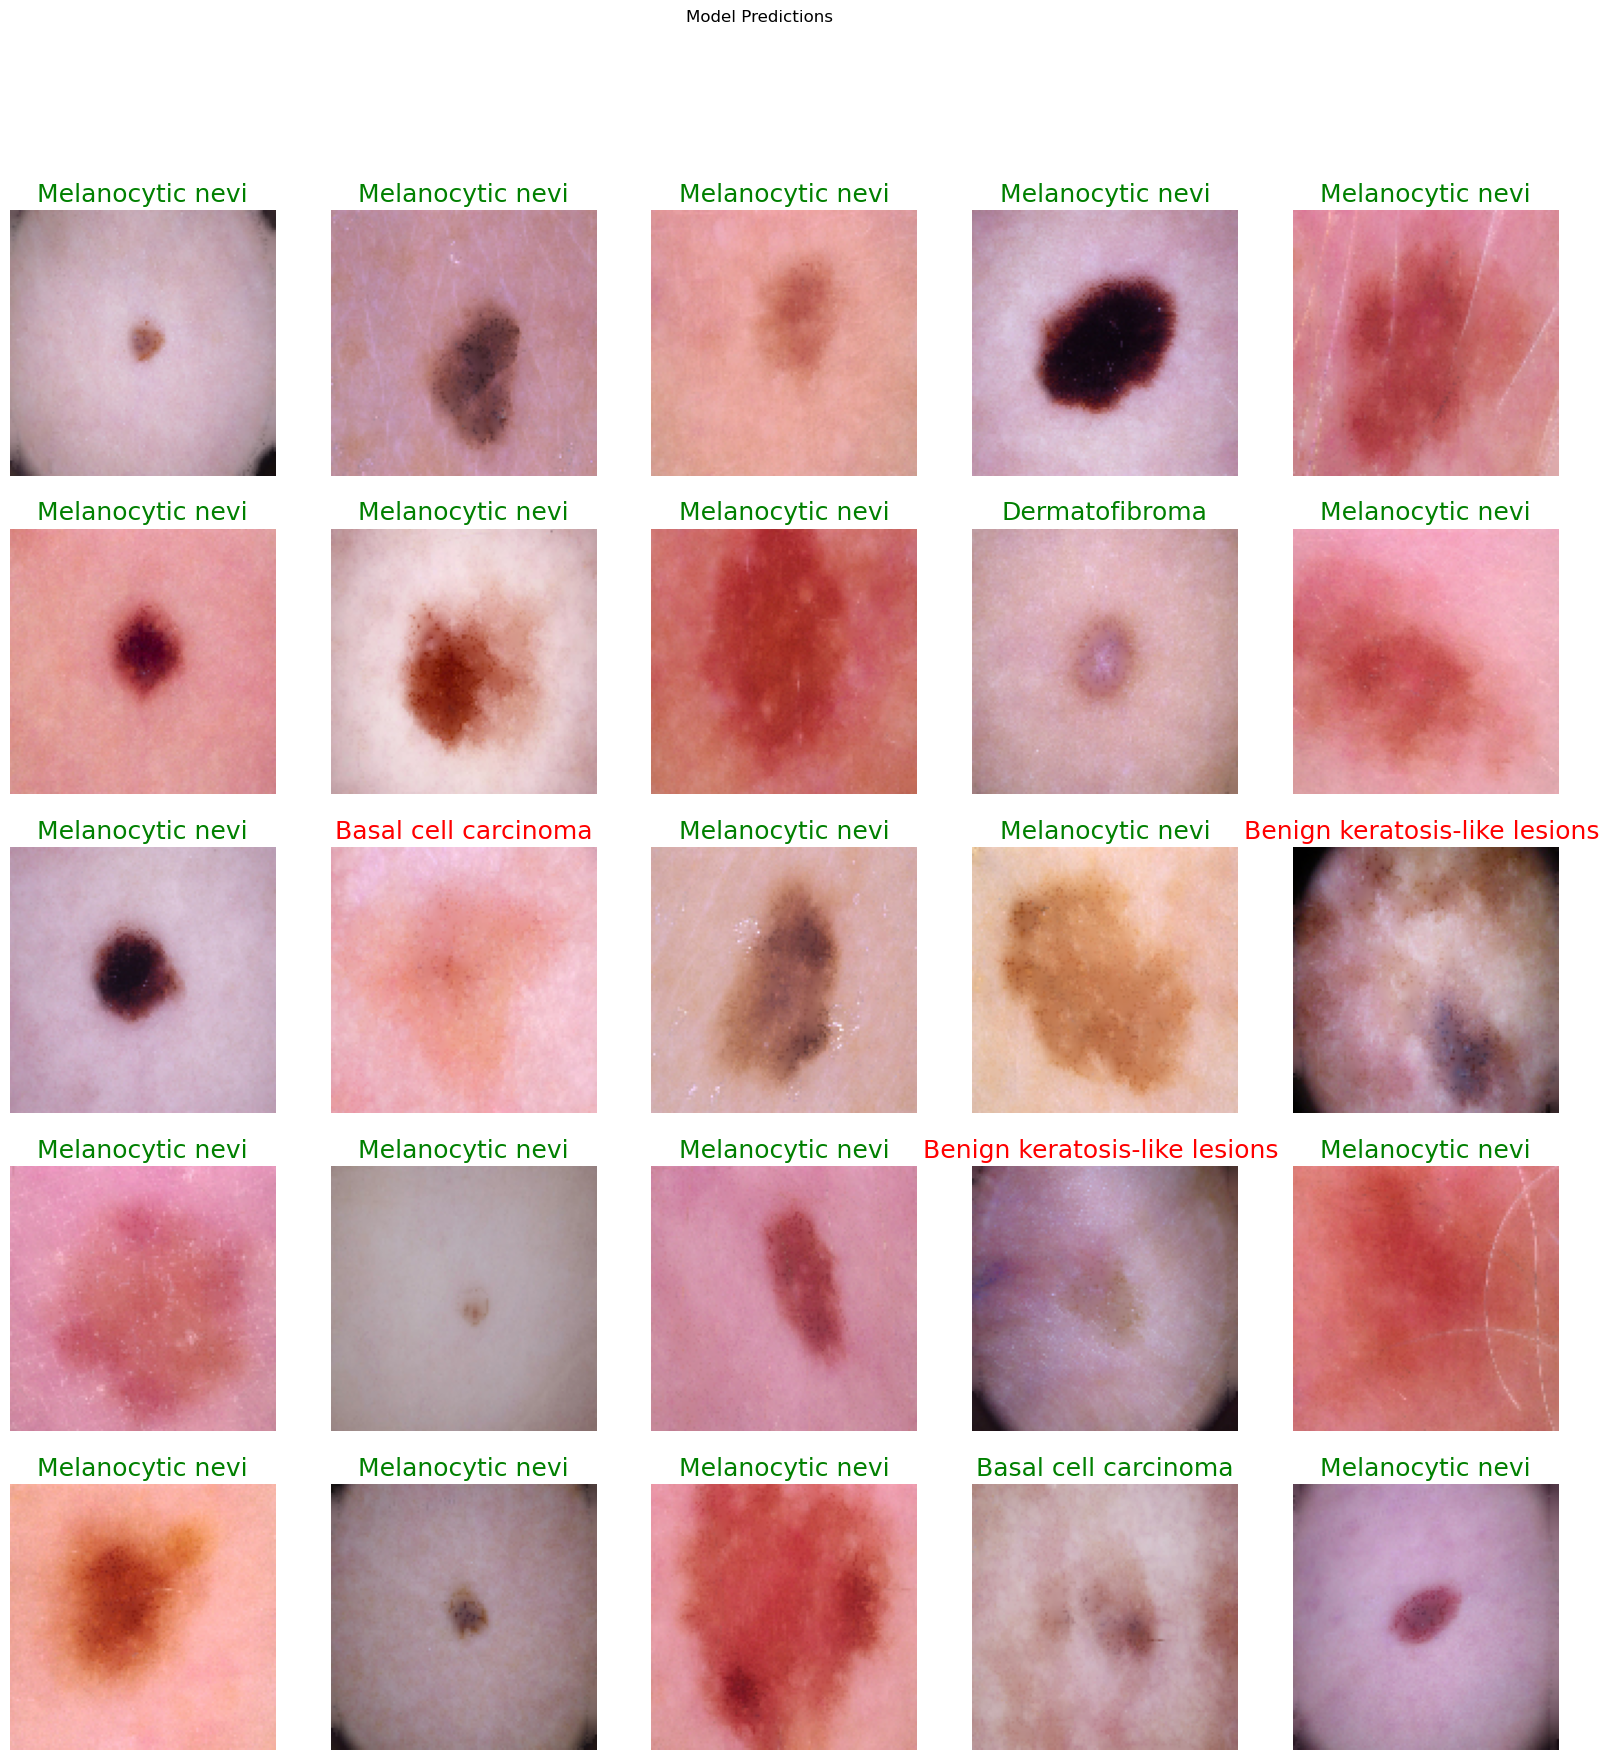

In [30]:
loss, accuracy = ResNet152_model.evaluate(x_test, y_test, verbose=0)
predictions = ResNet152_model.predict(x_test)
loss_v, accuracy_v = ResNet152_model.evaluate(x_validate, y_validate, verbose=0)
loss_t, accuracy_t = ResNet152_model.evaluate(x_train, y_train, verbose=0)
print("Training: accuracy = %f" % (accuracy_t))
print("Validation: accuracy = %f" % (accuracy_v))
print("Test: accuracy = %f" % (accuracy))
cm_pred(y_test_o,predictions)